In [25]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pathlib

In [2]:
data_dir = './data/multi-output-classification/dataset'
data_root = pathlib.Path(data_dir)
data_root

WindowsPath('data/multi-output-classification/dataset')

In [3]:
for item in data_root.iterdir():
    print(item)

data\multi-output-classification\dataset\black_jeans
data\multi-output-classification\dataset\black_shoes
data\multi-output-classification\dataset\blue_dress
data\multi-output-classification\dataset\blue_jeans
data\multi-output-classification\dataset\blue_shirt
data\multi-output-classification\dataset\red_dress
data\multi-output-classification\dataset\red_shirt


In [4]:
all_image_paths = list(data_root.glob('*/*'))
image_count = len(all_image_paths)
image_count

2525

In [5]:
all_image_paths[:3]

[WindowsPath('data/multi-output-classification/dataset/black_jeans/00000000.jpg'),
 WindowsPath('data/multi-output-classification/dataset/black_jeans/00000001.jpeg'),
 WindowsPath('data/multi-output-classification/dataset/black_jeans/00000002.jpeg')]

In [6]:
all_image_paths[-3:]

[WindowsPath('data/multi-output-classification/dataset/red_shirt/00000383.jpg'),
 WindowsPath('data/multi-output-classification/dataset/red_shirt/00000386.jpeg'),
 WindowsPath('data/multi-output-classification/dataset/red_shirt/00000388.jpg')]

In [7]:
import random
all_image_paths = [str(path) for path in all_image_paths]
random.shuffle(all_image_paths)

In [8]:
all_image_paths[:5]


['data\\multi-output-classification\\dataset\\black_shoes\\00000026.jpg',
 'data\\multi-output-classification\\dataset\\black_shoes\\00000160.jpg',
 'data\\multi-output-classification\\dataset\\black_jeans\\00000152.jpeg',
 'data\\multi-output-classification\\dataset\\black_jeans\\00000040.jpg',
 'data\\multi-output-classification\\dataset\\blue_jeans\\00000137.jpeg']

In [17]:
label_name = [i.split('\\')[-2] for i in all_image_paths]
label_name[:5]

['black_shoes', 'black_shoes', 'black_jeans', 'black_jeans', 'blue_jeans']

In [18]:
color_label_name = set(name.split("_")[0] for name in label_name)
color_label_name

{'black', 'blue', 'red'}

In [19]:
item_label_name = set(name.split("_")[1] for name in label_name)
item_label_name

{'dress', 'jeans', 'shirt', 'shoes'}

In [20]:
color_label_to_index = dict((name,index) for index,name in enumerate(color_label_name))
color_label_to_index

{'blue': 0, 'red': 1, 'black': 2}

In [21]:
item_label_to_index = dict((name,index) for index,name in enumerate(item_label_name))
item_label_to_index

{'jeans': 0, 'dress': 1, 'shirt': 2, 'shoes': 3}

In [22]:
color_labels = [color_label_to_index[label.split('_')[0]] for label in label_name]
color_labels[:5]

[2, 2, 2, 2, 0]

In [23]:
item_labels = [item_label_to_index[label.split('_')[1]] for label in label_name]
item_labels[:5]


[3, 3, 0, 0, 0]

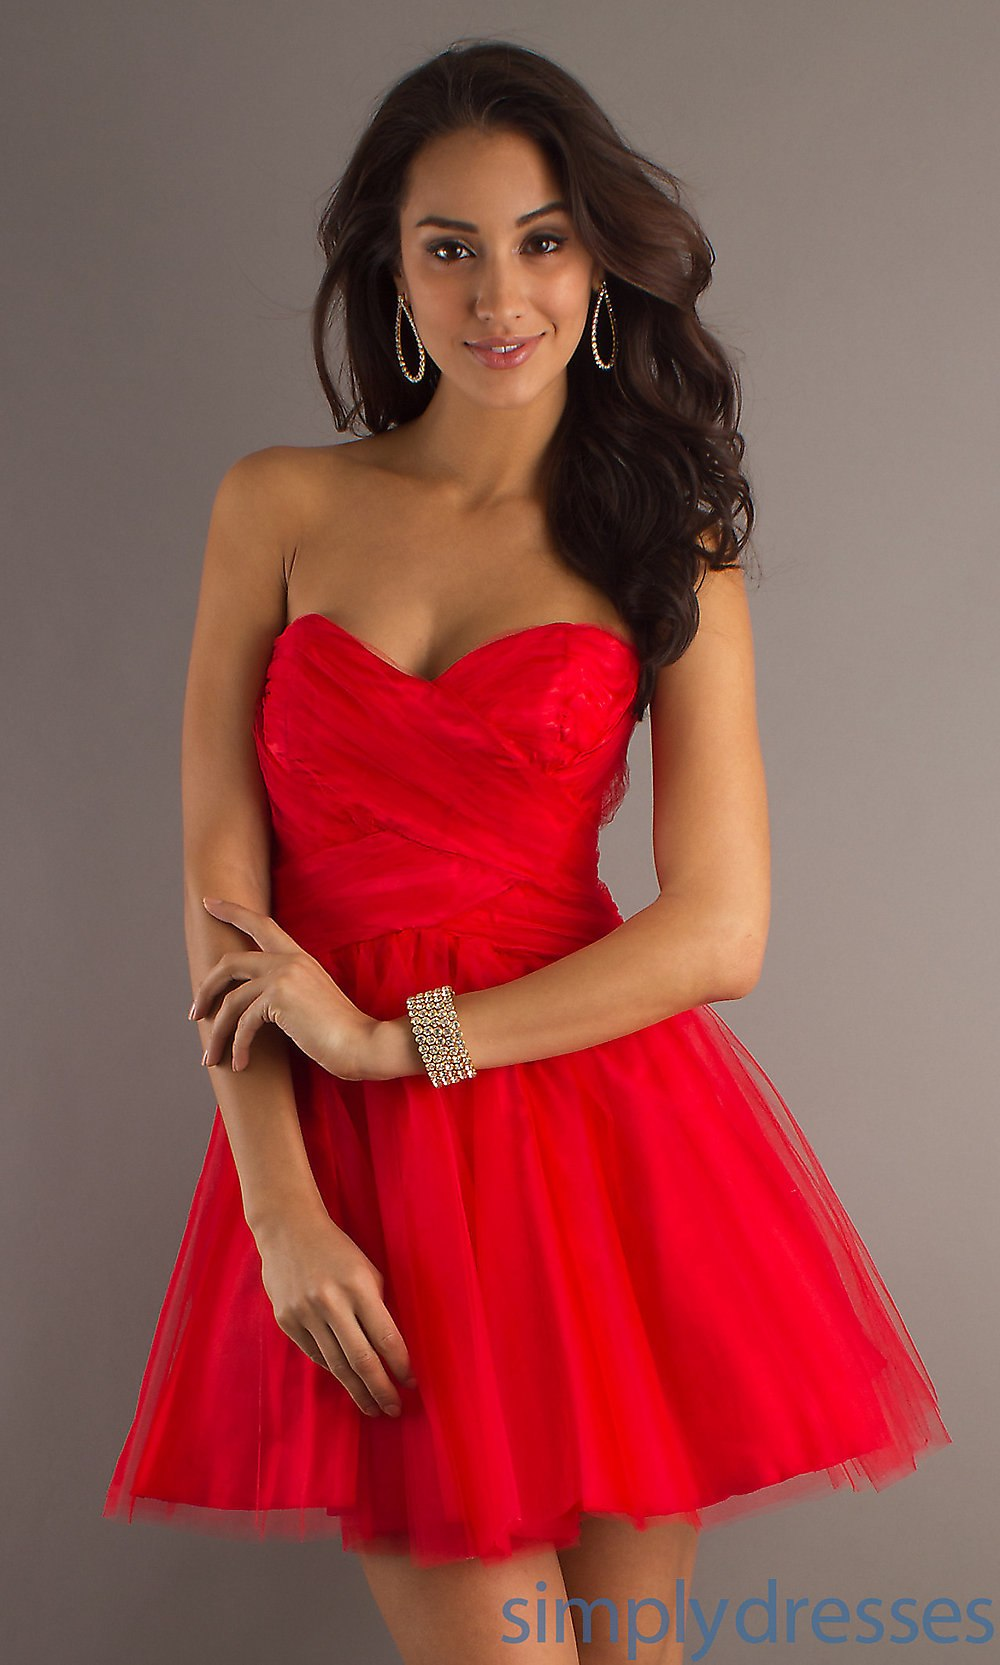

data\multi-output-classification\dataset\red_dress\00000053.jpg



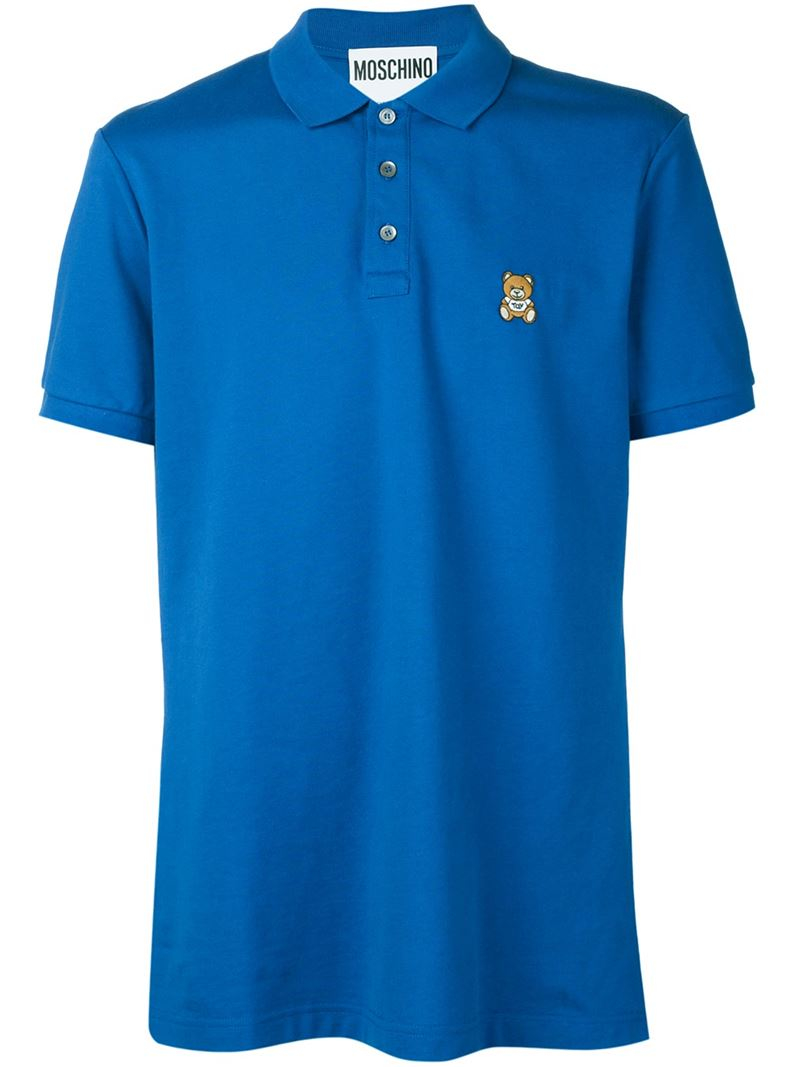

data\multi-output-classification\dataset\blue_shirt\00000170.jpeg



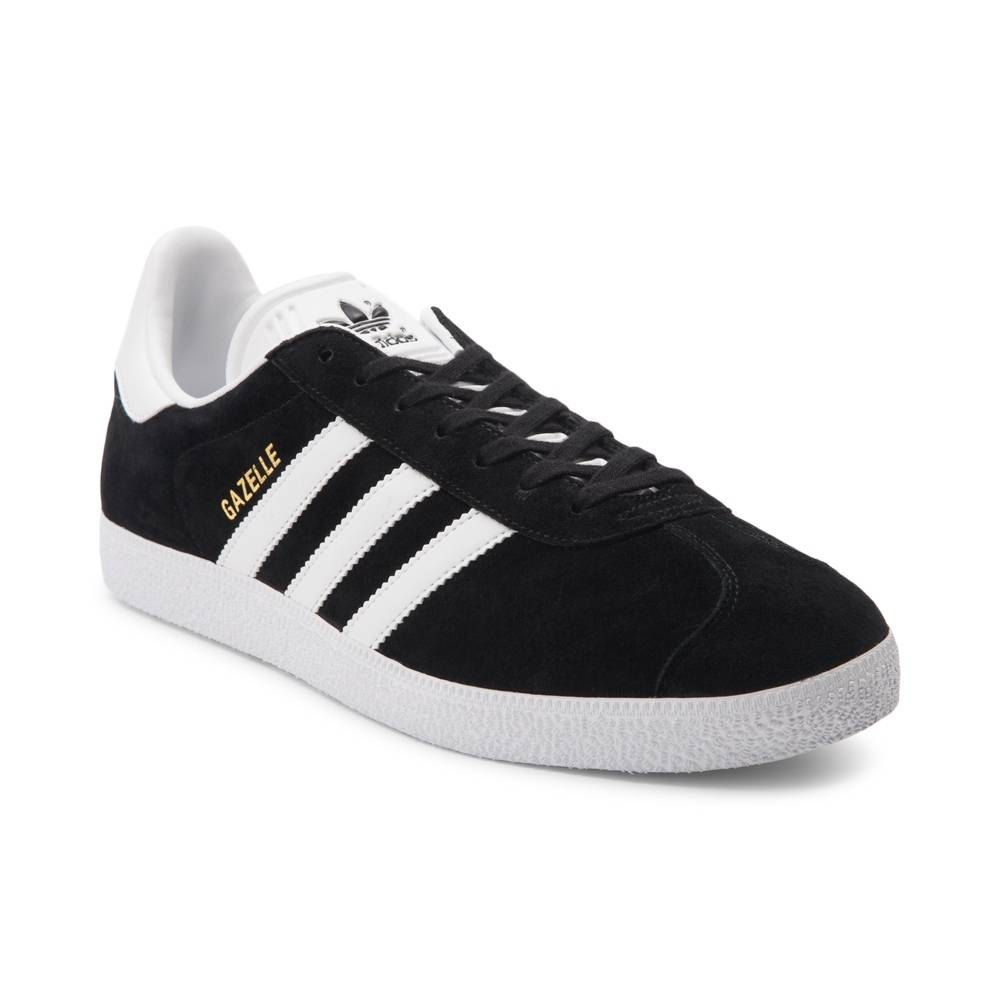

data\multi-output-classification\dataset\black_shoes\00000253.JPG



In [24]:
import IPython.display as display
for n in range(3):
    image_index = random.choice(range(len(all_image_paths)))
    display.display(display.Image(all_image_paths[image_index], width=100, height=100))
    print(all_image_paths[image_index])
    print()

In [27]:
img_raw = tf.io.read_file(all_image_paths[0])
print(repr(img_raw)[:100]+"...")

<tf.Tensor: shape=(), dtype=string, numpy=b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00...


In [28]:
img_tensor = tf.image.decode_image(img_raw)
print(img_tensor.shape)
print(img_tensor.dtype)

(1000, 1000, 3)
<dtype: 'uint8'>


In [29]:
def load_and_preprocess_iamge(path):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image,channels=3)
    image = tf.image.resize(image,[224,224])
    image = tf.cast(image, tf.float32)
    image = image/255.0
    image = 2*image-1
    return image

Text(0.5, 0, 'black_shoes')

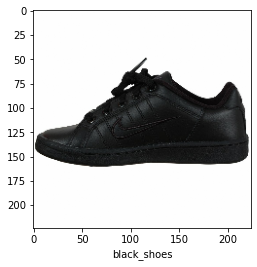

In [30]:
image_path = all_image_paths[0]
label = label_name[0]

plt.imshow((load_and_preprocess_iamge(image_path)+1)/2)
plt.grid(False)
plt.xlabel(label)

In [31]:
path_da = tf.data.Dataset.from_tensor_slices(all_image_paths)
AUTOTUNE = tf.data.experimental.AUTOTUNE
image_ds = path_da.map(load_and_preprocess_iamge,num_parallel_calls=AUTOTUNE)

In [32]:
label_ds = tf.data.Dataset.from_tensor_slices((color_labels,item_labels))
for ele in label_ds.take(3):
    print(ele[0].numpy(),ele[1].numpy())

2 3
2 3
2 0


In [98]:
image_label_ds = tf.data.Dataset.zip((image_ds,label_ds))
image_label_ds

<ZipDataset shapes: ((224, 224, 3), ((), ())), types: (tf.float32, (tf.int32, tf.int32))>

In [99]:
test_count = int(image_count*0.2)
train_count = image_count - test_count


In [100]:
train_data = image_label_ds.skip(test_count)
test_data = image_label_ds.take(test_count)

In [101]:
BATCH_SIZE = 32


In [102]:
train_data = train_data.shuffle(buffer_size=train_count).repeat(1)
train_data = train_data.batch(BATCH_SIZE)
train_data = train_data.prefetch(buffer_size=AUTOTUNE)
train_data

<PrefetchDataset shapes: ((None, 224, 224, 3), ((None,), (None,))), types: (tf.float32, (tf.int32, tf.int32))>

In [104]:
test_data = test_data.batch(BATCH_SIZE)

# 创建模型


In [59]:
mobile_net = tf.keras.applications.MobileNetV2(input_shape=(224,224,3), include_top=False)

In [60]:
inputs = tf.keras.Input(shape=(224,224,3))


In [61]:
x = mobile_net(inputs)
x.get_shape()

TensorShape([None, 7, 7, 1280])

In [62]:
x = keras.layers.GlobalAvgPool2D()(x)
x.get_shape()

TensorShape([None, 1280])

In [63]:
x1 = tf.keras.layers.Dense(1024,activation='relu')(x)
out_color = keras.layers.Dense(len(color_label_name),activation='softmax',name='out_color')(x1)

In [64]:
x2 = tf.keras.layers.Dense(1024,activation='relu')(x)
out_item = keras.layers.Dense(len(item_label_name),activation='softmax',name='out_item')(x2)

In [65]:
model = tf.keras.Model(inputs=inputs,
                       outputs=[out_color,out_item])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
mobilenetv2_1.00_224 (Functiona (None, 7, 7, 1280)   2257984     input_4[0][0]                    
__________________________________________________________________________________________________
global_average_pooling2d_3 (Glo (None, 1280)         0           mobilenetv2_1.00_224[0][0]       
__________________________________________________________________________________________________
dense_4 (Dense)                 (None, 1024)         1311744     global_average_pooling2d_3[0][0] 
____________________________________________________________________________________________

In [87]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

In [88]:
def loss_fn(c_r,c_p,i_r,i_p):
    color_loss = tf.keras.losses.sparse_categorical_crossentropy(c_r,c_p)
    item_loss = tf.keras.losses.sparse_categorical_crossentropy(i_r,i_p)
    return color_loss+item_loss

In [89]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_color_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_color_accuracy')
train_item_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_item_accuracy')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_color_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_color_accuracy')
test_item_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_item_accuracy')

In [90]:
@tf.function
def train_step(images,c_r,i_r):
    with tf.GradientTape() as tape:
        c_p,i_p = model(images)
        loss = loss_fn(c_r,c_p,i_r,i_p)

    gradients = tape.gradient(loss,model.trainable_variables)
    optimizer.apply_gradients(zip(gradients,model.trainable_variables))

    train_loss(loss)
    train_color_accuracy(c_r,c_p)
    train_item_accuracy(i_r,i_p)


In [91]:
@tf.function
def test_step(images,c_r,i_r):
    c_p,i_p = model(images)
    t_loss = loss_fn(c_r,c_p,i_r,i_p)

    test_loss(t_loss)
    test_color_accuracy(c_r,c_p)
    test_item_accuracy(i_r,i_p)

In [107]:
EPOCH =15

for epoch in range(EPOCH):
    train_loss.reset_state()
    train_color_accuracy.reset_state()
    train_item_accuracy.reset_state()
    test_loss.reset_state()
    test_color_accuracy.reset_state()
    test_item_accuracy.reset_state()

    print("#"*30)

    for images, (color_r,item_r) in train_data:
        train_step(images,color_r,item_r)

    for test_images,(test_color_r,test_item_r) in test_data:
        test_step(test_images,test_color_r,test_item_r)

    template = 'Epoch {}, Loss:{:.3f}, Color Accuracy:{:.3f}, Item Accuracy:{:.3f},\
               Test Loss:{:.3f},Test Color Accuracy:{:.3f},Test Item Accuracy:{:.3f}'
    print(template.format(
        epoch+1,
        train_loss.result(),
        train_color_accuracy.result(),
        train_item_accuracy.result(),
        test_loss.result(),
        test_color_accuracy.result(),
        test_item_accuracy.result()
    ))

##############################
Epoch 1, Loss:0.000, Color Accuracy:1.000, Item Accuracy:1.000,                Test Loss:0.260,Test Color Accuracy:0.990,Test Item Accuracy:0.988
##############################
Epoch 2, Loss:0.000, Color Accuracy:1.000, Item Accuracy:1.000,                Test Loss:0.260,Test Color Accuracy:0.990,Test Item Accuracy:0.988
##############################
Epoch 3, Loss:0.000, Color Accuracy:1.000, Item Accuracy:1.000,                Test Loss:0.261,Test Color Accuracy:0.990,Test Item Accuracy:0.988
##############################
Epoch 4, Loss:0.000, Color Accuracy:1.000, Item Accuracy:1.000,                Test Loss:0.261,Test Color Accuracy:0.990,Test Item Accuracy:0.988
##############################
Epoch 5, Loss:0.000, Color Accuracy:1.000, Item Accuracy:1.000,                Test Loss:0.261,Test Color Accuracy:0.990,Test Item Accuracy:0.988
##############################
Epoch 6, Loss:0.000, Color Accuracy:1.000, Item Accuracy:1.000,                Test 

In [76]:
model.compile(optimizer=tf.keras.optimizers.Adam(0.0001),
              # loss='spares_categorical_corssentropy',
              loss = {'out_color':tf.keras.losses.sparse_categorical_crossentropy,
                      'out_item':tf.keras.losses.sparse_categorical_crossentropy},
              metrics=['acc'])

In [67]:
train_steps = train_count//BATCH_SIZE
test_steps = test_count//BATCH_SIZE

In [77]:
model.fit(
    train_data,
    epochs=10,
    steps_per_epoch=train_steps,
    validation_data=test_data,
    validation_steps=test_steps
)

Epoch 1/10
63/63 [==============================] - 16s 142ms/step - loss: 0.0618 - out_color_loss: 0.0198 - out_item_loss: 0.0421 - out_color_acc: 0.9950 - out_item_acc: 0.9916 - val_loss: 33.7120 - val_out_color_loss: 22.7934 - val_out_item_loss: 10.9185 - val_out_color_acc: 0.6687 - val_out_item_acc: 0.4083

In [ ]:
model.set_weights('my_multi_output_model.h5')

In [78]:
my_image_path = 'data/multi-output-classification/examples/black_dress.jpg'
my_img = load_and_preprocess_iamge(my_image_path)

In [79]:
my_img.shape

TensorShape([224, 224, 3])

In [80]:
my_img = tf.expand_dims(my_img,0)
my_img.shape

TensorShape([1, 224, 224, 3])

In [81]:
pred = model.predict(my_img)
pred

[array([[1.0000000e+00, 0.0000000e+00, 5.6646135e-28]], dtype=float32),
 array([[1.7154473e-13, 1.0000000e+00, 1.6617391e-10, 3.2589153e-19]],
       dtype=float32)]

In [82]:
pred2 = model(my_img)
pred2

[<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[1.000000e+00, 0.000000e+00, 5.320499e-28]], dtype=float32)>,
 <tf.Tensor: shape=(1, 4), dtype=float32, numpy=
 array([[1.7467011e-13, 1.0000000e+00, 1.7041663e-10, 3.3089859e-19]],
       dtype=float32)>]

In [85]:
np.argmax(pred[0])

0

In [86]:
np.argmax(pred[1])

1